![Lifeboat](images/lifeboat-around-Titanic.jpg)

# What is Logistic Regression?
<div align=center>$y = m x + b$</div>
![](images/lgJON.gif)

![](images/NcMaQ.gif)

In [1]:
import os
os.environ['PYSPARK_SUBMIT_ARGS'] = "--packages com.databricks:spark-csv_2.10:1.3.0 pyspark-shell"

from pyspark import SparkContext, SparkConf, StorageLevel
from pyspark.sql import SQLContext, HiveContext
import py4j
from time import time

conf = SparkConf().setAppName("SparkJupyterTitanic") \
        .setMaster("yarn-client") \
        .set("spark.executor.memory", "4g") \
        .set("spark.executor.cores", 3) \
        .set("spark.executor.instances", 2) # 2 ==> 4
        
sc = SparkContext(conf=conf)

try:
    # Try to access HiveConf, it will raise exception if Hive is not added
    sc._jvm.org.apache.hadoop.hive.conf.HiveConf()
    sqlContext = HiveContext(sc)
except py4j.protocol.Py4JError:
    sqlContext = SQLContext(sc)
except TypeError:
    sqlContext = SQLContext(sc)
sc

In [2]:
csv = "s3n://ltsai/smu-talk-8mar2016/csv/titanic3.csv" # 1.3K rows
#csv = "s3n://ltsai/smu-talk-8mar2016/csv/1.csv" # There are 2 CSV, each is 1GB. ~13M rows 
#csv = "s3n://ltsai/smu-talk-8mar2016/csv/*.csv" 

In [3]:
from pyspark.sql.types import *
customSchema = StructType([StructField('pclass', StringType(), True),
                           StructField('survived', IntegerType(), True),
                           StructField('name', StringType(), True),
                           StructField('sex', StringType(), True),
                           StructField('age', StringType(), True),
                           StructField('sibsp', IntegerType(), True),
                           StructField('parch', IntegerType(), True),
                           StructField('ticket', StringType(), True),
                           StructField('fare', FloatType(), True),
                           StructField('cabin', StringType(), True),
                           StructField('embarked', StringType(), True),
                           StructField('boat', StringType(), True),
                           StructField('body', StringType(), True),
                           StructField('home.dest', StringType(), True)])
df = sqlContext.read.format('com.databricks.spark.csv'). \
        options(header='true', treatEmptyValuesAsNulls='true'). \
        load(csv, schema = customSchema)

In [4]:
train_df, test_df = df.select("survived", "pclass", "sibsp", "parch").randomSplit([0.8, 0.2])

In [5]:
from pyspark.sql import Row
from pyspark.mllib.linalg import Vectors

ntrain = train_df.map(lambda x: Row(label = float(x[0]) \
         ,features = Vectors.dense(x[1:]))).toDF().persist(StorageLevel.MEMORY_AND_DISK) 
ntest = test_df.map(lambda x: Row(features = Vectors.dense(x[1:]))).toDF()

from time import time
t0 = time()
print ntrain.count(), ntest.count()
t1 = time()

# 10471301 2618699
# Time Taken 220.47 seconds (1 CSV)
# Time Taken 436.52 seconds (2 CSV)

# After scaling 6 => 12 cores
# Time Taken 150.24 seconds (1 CSV)
# Time Taken 227.63 seconds (2 CSV)
print 'Time Taken ' + str(round(t1 - t0,2)) + ' seconds'

20946346 5233654
Time Taken 436.52 seconds


In [6]:
from pyspark.ml.classification import LogisticRegression
lr = LogisticRegression(maxIter=100)

In [9]:
t0 = time()
model = lr.fit(ntrain)
t1 = time()

# Time Taken 18.55 seconds (1 CSV)
# Time Taken 62.42 seconds (2 CSV)

# After scaling 6 => 12 cores
# Time Taken 23.35 seconds (1 CSV)
# Time Taken 17.56 seconds (2 CSV)
print 'Time Taken ' + str(round(t1 - t0,2)) + ' seconds'

Time Taken 59.59 seconds


In [10]:
pred = model.transform(ntest)

/usr/lib/spark/python/pyspark/ml/classification.py:207: UserWarning: weights is deprecated. Use coefficients instead.
  warnings.warn("weights is deprecated. Use coefficients instead.")


In [11]:
pred.where("prediction = 1.0").count()/float(test_df.where("survived=1").count())

0.658456903370474

In [19]:
sc.stop()

# Let's resize the EMR cluster

Increase core count to 4 and wait.

![](images/Screen Shot 2016-03-07 at 10.14.40 am.png)

Once the cluster has been resized, go to YARN resource manager and observe the increased compute resources.

In [19]:
import pandas as pd

time_df = pd.DataFrame({'6 core' : [436,227], '12 cores' : [62,17]}, index=['read','lr.fit'])
time_df

,12 cores,6 core
read,62,436
lr.fit,17,227


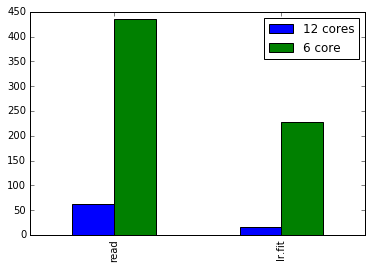

In [21]:
%matplotlib inline
time_df.plot(kind='bar')